In [1]:
pip install mlrose-hiive

     |████████████████████████████████| 49 kB 3.3 MB/s 
  Created wheel for mlrose-hiive: filename=mlrose_hiive-2.2.4-py3-none-any.whl size=98351 sha256=ad7d6791d3fb0853b9906cdb43180efcb1a1cafd3b26bb768517028580c331cf
  Stored in directory: /root/.cache/pip/wheels/ca/9c/44/36113054dda94da67040173c2a475dbfb6980c2c6ddf5747b1
Successfully built mlrose-hiive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML # for some notebook formatting.

import mlrose_hiive
import numpy as np
import logging
import networkx as nx
import matplotlib.pyplot as plt
import string


from ast import literal_eval
import chess

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import SARunner, GARunner, NNGSRunner, RHCRunner, MIMICRunner

# switch off the chatter
logging.basicConfig(level=logging.WARNING)

In [96]:
def iter_final_compare (num_iter, fit_1, fit_2, fit_3, fit_4, label_1, label_2, label_3, label_4, xlabel, ylabel, title):
  plt.figure(figsize=(14,10))
  plt.grid()
  plt.title(f'{title} Best Runners Comparison', fontsize = 18)
  plt.plot(num_iter, fit_1, label= label_1, color='r')
  plt.plot(num_iter, fit_2, label= label_2, color='b')
  plt.plot(num_iter, fit_3, label= label_3, color='g')
  plt.plot(num_iter, fit_4, label= label_4, color='black')
  plt.xlabel(xlabel, fontsize = 18)
  plt.ylabel(ylabel, fontsize = 18)
  plt.legend(loc='best')

In [108]:
def iter_final3_compare (num_iter, fit_1, fit_2, fit_3, label_1, label_2, label_3, xlabel, ylabel, title):
  plt.figure(figsize=(14,10))
  plt.grid()
  plt.title(f'{title} Best Runners Comparison', fontsize = 18)
  plt.plot(num_iter, fit_1, label= label_1, color='r')
  plt.plot(num_iter, fit_2, label= label_2, color='b')
  plt.plot(num_iter, fit_3, label= label_3, color='g')
  plt.xlabel(xlabel, fontsize = 18)
  plt.ylabel(ylabel, fontsize = 18)
  plt.legend(loc='best')

In [39]:
def iter_score (num_iter, fit, method):
  plt.figure(figsize=(14,10))
  plt.grid()
  plt.plot(num_iter, fit)
  plt.title(f'Fitness Score - Number of Iteration on {method}', fontsize = 18)
  plt.xlabel('# Iteration', fontsize = 18)
  plt.ylabel('Fitness Score', fontsize = 18)
  plt.show()

In [3]:
#Mount to drive and laod data
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [4]:
#Go to Assignment directory
%cd '/content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Loan_Model_DT'

/content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Loan_Model_DT


In [5]:
df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name= 'Data')

X = df.drop(['Personal Loan', 'ID', 'ZIP Code'], axis=1)
y = df['Personal Loan']
df.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')

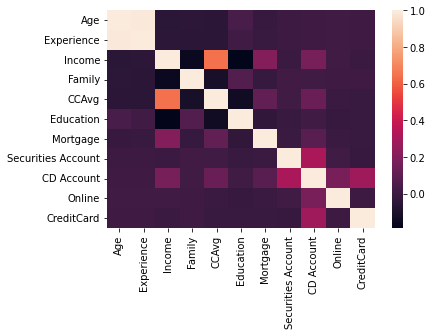

In [6]:
# Checking Corelation heatmap
import seaborn as sns
corr = X.corr()
sns.heatmap(corr)

In [7]:
#Dropping Age column for colinearity
X.drop('Age', axis=1, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4185a1ec10>,
      dtype=object)

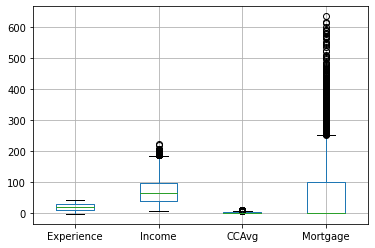

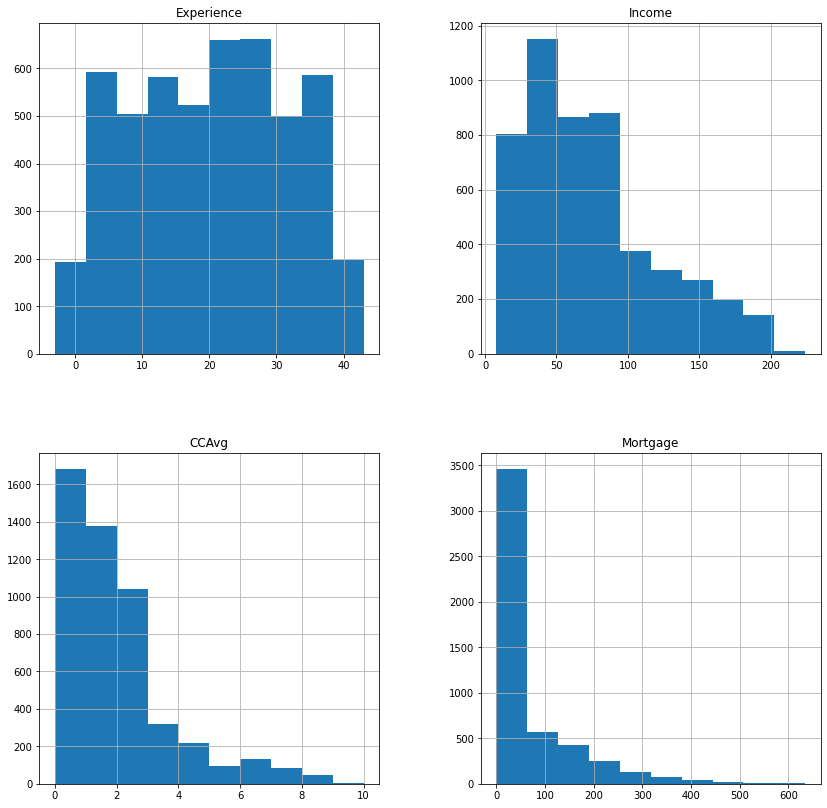

In [8]:
#EDA Analysis
continues_variables = X[['Experience', 'Income', 'CCAvg', 'Mortgage']]
continues_variables.boxplot() #See a large variation btw features need standardization.
continues_variables.hist(figsize=(14,14))

In [9]:
#Split the dataset to train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25,
                                                    random_state=27,stratify=y)

In [10]:
# One hot encode target values
one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(y_train.values.reshape(-1, 1)).todense()
y_test_hot = one_hot.transform(y_test.values.reshape(-1, 1)).todense()

In [11]:
#Check Label Distribution Across splits
print(y.value_counts())
print(y_train.value_counts())
print(y_test.value_counts())

0    4520
1     480
Name: Personal Loan, dtype: int64
0    3390
1     360
Name: Personal Loan, dtype: int64
0    1130
1     120
Name: Personal Loan, dtype: int64


In [13]:
#Make Copy of X_train and X_val, X_test
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

#Group Columns based on type
normal_col = ['Experience']
skewd_col = ['Income', 'CCAvg', 'Mortgage']
cat_col = ['Family', 'Education']

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer

normal_pipeline = Pipeline(steps = [('scale', StandardScaler())])
skewd_pipline = Pipeline(steps = [('sk_scale', PowerTransformer())])
cat_pipeline = Pipeline(steps=[('one_hot', OneHotEncoder())])

full_preprocessor = ColumnTransformer(transformers=[
        ('normal_transform', normal_pipeline, normal_col),
        ('skewd_transform', skewd_pipline, skewd_col),
        ('Categorical_onhot', cat_pipeline, cat_col)],remainder ='passthrough')

X_train_stand = full_preprocessor.fit_transform(X_train_stand)
X_test_stand = full_preprocessor.transform(X_test_stand)

In [140]:
grid_search_parameters_grad = {
    'max_iters': [1000],                          # nn params
    'learning_rate': [0.000001],                    # nn params
    'activation': [mlrose_hiive.relu]}            # nn param

nnr_grad = NNGSRunner(
    x_train=X_train_stand,
    y_train=y_train_hot,
    x_test=X_test_stand,
    y_test=y_test_hot,
    experiment_name='nn_grad',
    algorithm = mlrose_hiive.algorithms.gd.gradient_descent,
    grid_search_parameters=grid_search_parameters_grad,
    iteration_list=[64, 128, 256, 512, 1024, 2048],
    hidden_layer_sizes=[[20]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=0,
    output_directory=None
)



run_stats_df_grad, curves_df_grad, cv_results_df_grad, grid_search_cv_grad = nnr_grad.run()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [141]:
y_test_pred_grad = grid_search_cv_grad.predict(X_test_stand)
y_test_accuracy_grad = accuracy_score(y_test_hot, y_test_pred_grad)
print(y_test_accuracy_grad)

0.904


In [142]:
from sklearn.metrics import f1_score, classification_report
print(f'\nClassification report on test set (Gradient Decent):\n\n {classification_report(y_test_hot, y_test_pred_grad, zero_division=1)}')
print(f'\nClassification report on training set (Gradient Decent):\n\n {classification_report(y_train_hot, grid_search_cv_grad.predict(X_train_stand), zero_division=1)}')


Classification report on test set (Gradient Decent):

               precision    recall  f1-score   support

           0       0.90      1.00      0.95      1130
           1       1.00      0.00      0.00       120

   micro avg       0.90      0.90      0.90      1250
   macro avg       0.95      0.50      0.47      1250
weighted avg       0.91      0.90      0.86      1250
 samples avg       0.90      0.90      0.90      1250


Classification report on training set (Gradient Decent):

               precision    recall  f1-score   support

           0       0.90      1.00      0.95      3390
           1       1.00      0.00      0.00       360

   micro avg       0.90      0.90      0.90      3750
   macro avg       0.95      0.50      0.47      3750
weighted avg       0.91      0.90      0.86      3750
 samples avg       0.90      0.90      0.90      3750



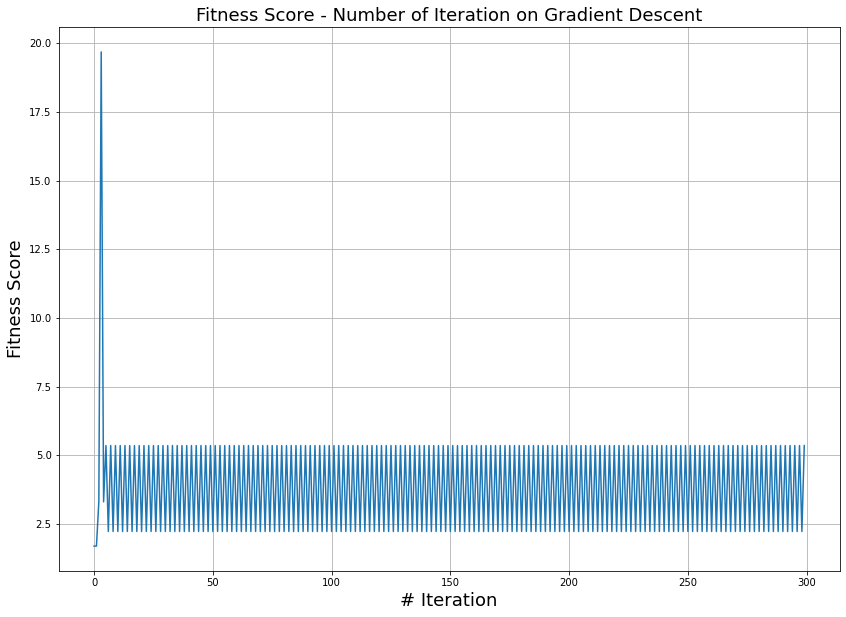

In [136]:
iter_score(curves_df_grad['Iteration'].iloc()[:300], curves_df_grad['Fitness'].iloc()[:300], 'Gradient Descent')

In [43]:
grid_search_parameters_rhc = {
    'max_iters': [6000],                         # nn params
    'learning_rate': [1e-2],                     # nn params
    'activation': [mlrose_hiive.sigmoid],        # nn params
    'restarts': [1],                             # rhc params
}

nn_rhc = NNGSRunner(
    x_train=X_train_stand,
    y_train=y_train_hot,
    x_test=X_test_stand,
    y_test=y_test_hot,
    experiment_name='nn_rhc',
    algorithm= mlrose_hiive.algorithms.rhc.random_hill_climb,
    grid_search_parameters=grid_search_parameters_rhc,
    iteration_list= [32, 64, 128, 256, 512, 1024, 2048],
    hidden_layer_sizes=[[20]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=0,
    output_directory=None
)


run_stats_df_rhc, curves_df_rhc, cv_results_df_rhc, grid_search_cv_rhc = nn_rhc.run()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


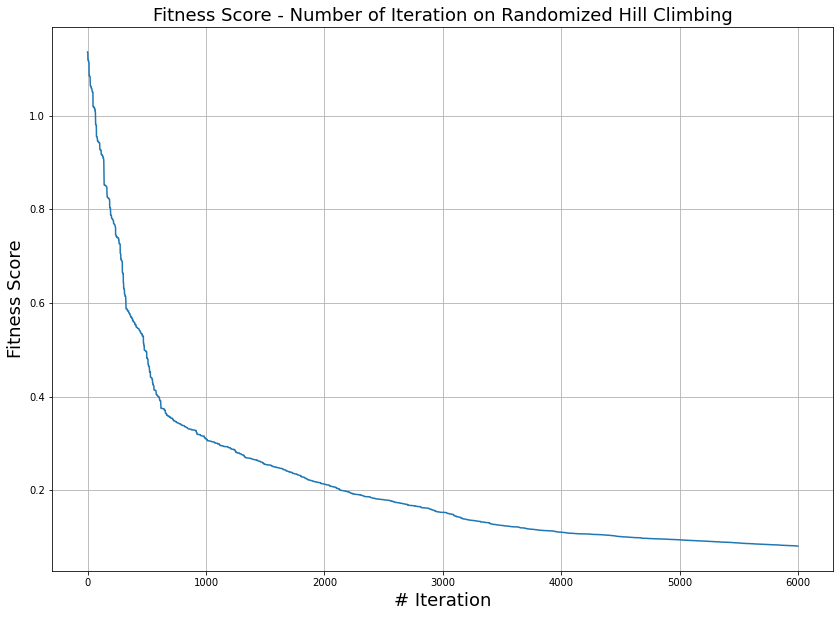

In [94]:
iter_score(curves_df_rhc['Iteration'].iloc()[:6000], curves_df_rhc['Fitness'].iloc()[:6000], 'Randomized Hill Climbing')

In [44]:
y_test_pred_rhc = grid_search_cv_rhc.predict(X_test_stand)
y_test_accuracy_rhc = accuracy_score(y_test_hot, y_test_pred_rhc)
print(y_test_accuracy_rhc)

0.976


In [45]:
from sklearn.metrics import f1_score, classification_report
print(f'\nClassification report on test set (RHC):\n\n {classification_report(y_test_hot, y_test_pred_rhc, zero_division=1)}')
print(f'\nClassification report on training set (RHC):\n\n {classification_report(y_train_hot, grid_search_cv_rhc.predict(X_train_stand), zero_division=1)}')


Classification report on test set (RHC):

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1130
           1       0.95      0.79      0.86       120

   micro avg       0.98      0.98      0.98      1250
   macro avg       0.96      0.89      0.93      1250
weighted avg       0.98      0.98      0.98      1250
 samples avg       0.98      0.98      0.98      1250


Classification report on training set (RHC):

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3390
           1       0.95      0.78      0.86       360

   micro avg       0.97      0.97      0.97      3750
   macro avg       0.96      0.89      0.92      3750
weighted avg       0.97      0.97      0.97      3750
 samples avg       0.97      0.97      0.97      3750



In [70]:
grid_search_parameters_sa = {
    'max_iters': [6000],                          # nn params
    'learning_rate': [1e-2],                      # nn params
    'activation': [mlrose_hiive.sigmoid],         # nn params
    'schedule': [mlrose_hiive.GeomDecay(2)],     #sa params
}

nn_sa = NNGSRunner(
    x_train=X_train_stand,
    y_train=y_train_hot,
    x_test=X_test_stand,
    y_test=y_test_hot,
    experiment_name='nn_sa',
    algorithm= mlrose_hiive.algorithms.sa.simulated_annealing,
    grid_search_parameters = grid_search_parameters_sa,
    iteration_list= [32, 64, 128, 256, 512, 1024, 2048],
    hidden_layer_sizes=[[20]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=500,
    n_jobs=5,
    seed=0,
    output_directory=None
)


run_stats_df_sa, curves_df_sa, cv_results_df_sa, grid_search_cv_sa = nn_sa.run()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [71]:
y_test_pred_sa = grid_search_cv_sa.predict(X_test_stand)
y_test_accuracy_sa = accuracy_score(y_test_hot, y_test_pred_sa)
print(y_test_accuracy_sa)

0.9304


In [72]:
from sklearn.metrics import f1_score, classification_report
print(f'\nClassification report on test set (SA):\n\n {classification_report(y_test_hot, y_test_pred_sa, zero_division=1)}')
print(f'\nClassification report on training set (SA):\n\n {classification_report(y_train_hot, grid_search_cv_sa.predict(X_train_stand), zero_division=1)}')


Classification report on test set (SA):

               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1130
           1       0.92      0.30      0.45       120

   micro avg       0.93      0.93      0.93      1250
   macro avg       0.93      0.65      0.71      1250
weighted avg       0.93      0.93      0.91      1250
 samples avg       0.93      0.93      0.93      1250


Classification report on training set (SA):

               precision    recall  f1-score   support

           0       0.93      1.00      0.96      3390
           1       0.94      0.33      0.49       360

   micro avg       0.93      0.93      0.93      3750
   macro avg       0.94      0.66      0.73      3750
weighted avg       0.93      0.93      0.92      3750
 samples avg       0.93      0.93      0.93      3750



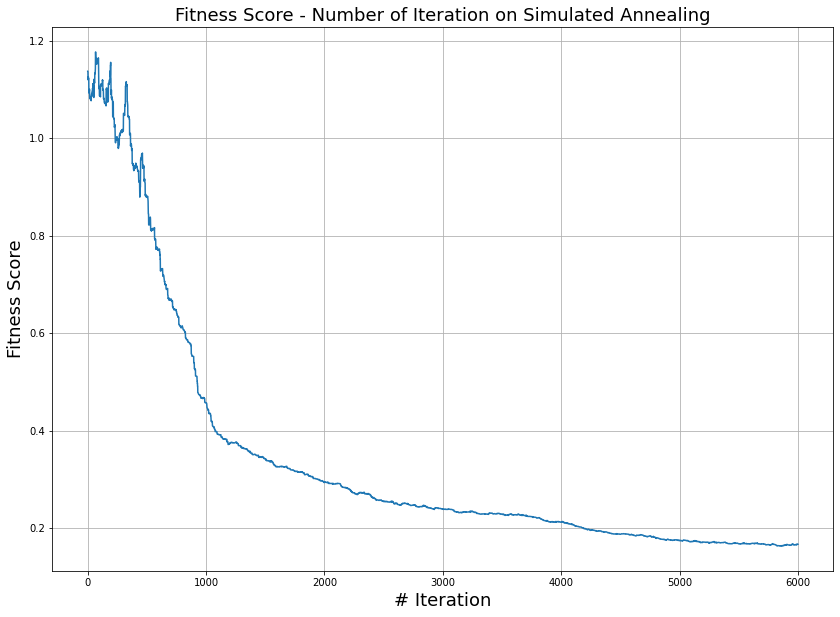

In [95]:
iter_score(curves_df_sa['Iteration'].iloc()[:6000], curves_df_sa['Fitness'].iloc()[:6000], 'Simulated Annealing')

In [100]:
grid_search_parameters_ga = {
    'max_iters': [1000],                          # nn params
    'learning_rate': [0.01],                      # nn params
    'activation': [mlrose_hiive.sigmoid],         # nn params
    'pop_size': [50],
    'mutation_prob': [0.8]
}

nn_ga = NNGSRunner(
    x_train=X_train_stand,
    y_train=y_train_hot,
    x_test=X_test_stand,
    y_test=y_test_hot,
    experiment_name='nn_ga',
    algorithm= mlrose_hiive.algorithms.ga.genetic_alg,
    grid_search_parameters = grid_search_parameters_ga,
    iteration_list=[32, 64, 128, 256, 512, 1024, 2048],
    hidden_layer_sizes=[[20]],
    bias=True,
    early_stopping=True,
    clip_max=5,
    max_attempts=1000,
    n_jobs=5,
    seed=0,
    output_directory=None
)


run_stats_df_ga, curves_df_ga, cv_results_df_ga, grid_search_cv_ga = nn_ga.run()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [101]:
y_test_pred_ga = grid_search_cv_ga.predict(X_test_stand)
y_test_accuracy_ga = accuracy_score(y_test_hot, y_test_pred_ga)
print(y_test_accuracy_ga)

0.9232


In [102]:
from sklearn.metrics import f1_score, classification_report
print(f'\nClassification report on test set (Genetic Algorithm):\n\n {classification_report(y_test_hot, y_test_pred_ga, zero_division=1)}')
print(f'\nClassification report on training set (Genetic Algorithm):\n\n {classification_report(y_train_hot, grid_search_cv_ga.predict(X_train_stand), zero_division=1)}')


Classification report on test set (Genetic Algorithm):

               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1130
           1       0.63      0.49      0.55       120

   micro avg       0.92      0.92      0.92      1250
   macro avg       0.79      0.73      0.75      1250
weighted avg       0.92      0.92      0.92      1250
 samples avg       0.92      0.92      0.92      1250


Classification report on training set (Genetic Algorithm):

               precision    recall  f1-score   support

           0       0.95      0.97      0.96      3390
           1       0.62      0.49      0.54       360

   micro avg       0.92      0.92      0.92      3750
   macro avg       0.78      0.73      0.75      3750
weighted avg       0.92      0.92      0.92      3750
 samples avg       0.92      0.92      0.92      3750



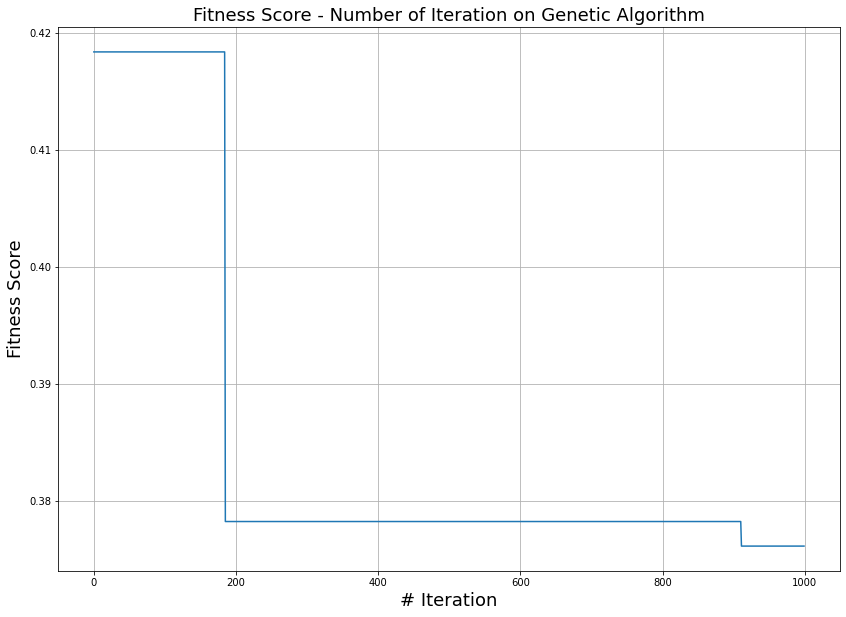

In [103]:
iter_score(curves_df_ga['Iteration'].iloc()[:1000], curves_df_ga['Fitness'].iloc()[:1000], 'Genetic Algorithm')

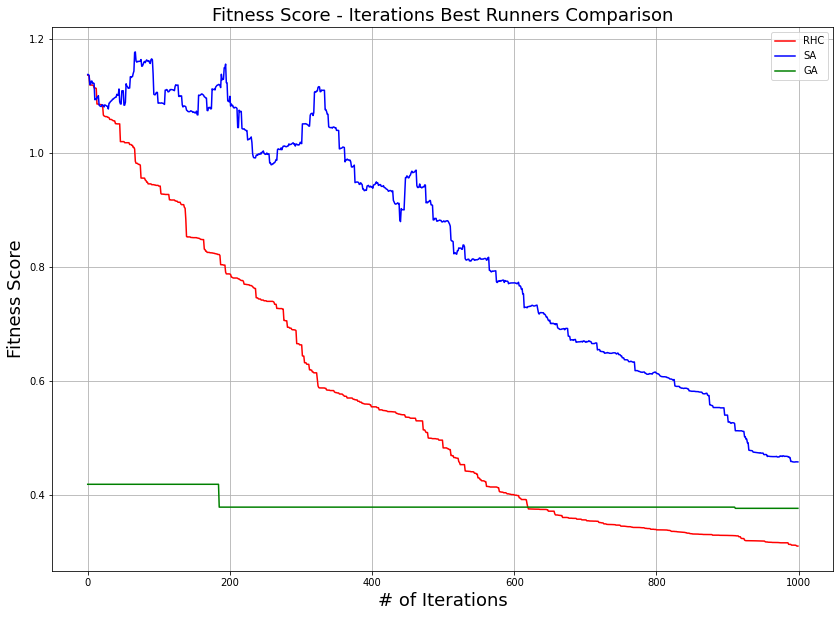

In [109]:
iter_final3_compare(curves_df_grad['Iteration'].iloc()[0:1000], curves_df_rhc['Fitness'].iloc()[:1000], curves_df_sa['Fitness'].iloc()[:1000], curves_df_ga['Fitness'].iloc()[:1000], 'RHC', 'SA', 'GA', '# of Iterations'
, 'Fitness Score', 'Fitness Score - Iterations')

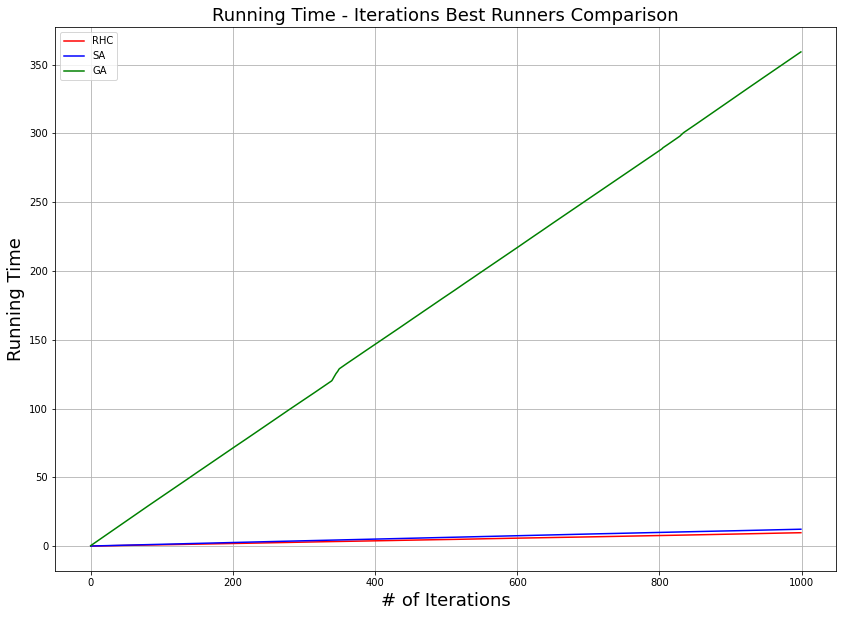

In [111]:
iter_final3_compare(curves_df_grad['Iteration'].iloc()[0:1000], curves_df_rhc['Time'].iloc()[:1000], curves_df_sa['Time'].iloc()[:1000], curves_df_ga['Time'].iloc()[:1000], 'RHC', 'SA', 'GA', '# of Iterations'
, 'Running Time', 'Running Time - Iterations')